In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
# ============================================
# 2. Load dataset
# ============================================
# Jika encoding error, encoding='latin1' biasanya aman untuk file ini.
df = pd.read_csv("Sample - Superstore.csv", encoding="latin1")

print("Shape data:", df.shape)
print(df.head())

Shape data: (9994, 21)
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category 

In [3]:
# ============================================
# 3. Feature engineering tanggal
#    - Ubah Order Date & Ship Date ke datetime
#    - Buat fitur baru: tahun, bulan, lama pengiriman (hari)
# ============================================
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

df["OrderYear"] = df["Order Date"].dt.year
df["OrderMonth"] = df["Order Date"].dt.month
df["ShipDays"] = (df["Ship Date"] - df["Order Date"]).dt.days

In [4]:
# ============================================
# 4. Pilih label (target) dan fitur
#    Target terbaik: 'Segment' (Consumer / Corporate / Home Office)
# ============================================
target_col = "Segment"

# Kolom-kolom yang dibuang karena:
# - ID unik atau terlalu spesifik (tidak generalizable)
# - Date asli diganti dengan fitur turunan di atas
drop_cols = [
    "Row ID",
    "Order ID",
    "Customer ID",
    "Customer Name",
    "Country",
    "Order Date",
    "Ship Date",
]

df_model = df.drop(columns=drop_cols)

# Cek nilai unik target
print("\nDistribusi target (Segment):")
print(df_model[target_col].value_counts())


Distribusi target (Segment):
Segment
Consumer       5191
Corporate      3020
Home Office    1783
Name: count, dtype: int64


In [5]:
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (9994, 16)
y shape: (9994,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)


Shape X_train: (7995, 16)
Shape X_test : (1999, 16)


In [7]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Kolom numerik:", numeric_cols)
print("Kolom kategorikal:", categorical_cols)

Kolom numerik: ['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit', 'ShipDays']
Kolom kategorikal: ['Ship Mode', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']


In [8]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


In [9]:
svc = LinearSVC(random_state=42)
sgd = SGDClassifier(loss="hinge", max_iter=5000, tol=1e-3, random_state=42)
ridge = RidgeClassifier(random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ("svc", svc),
        ("sgd", sgd),
        ("ridge", ridge),
    ],
    voting="hard"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", ensemble)
])


In [10]:
print("Training model (Voting Ensemble - No DT)...")
model.fit(X_train, y_train)
print("Selesai training.")


Training model (Voting Ensemble - No DT)...
Selesai training.


In [11]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Akurasi di data test: {:.4f}".format(acc))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Akurasi di data test: 0.4837

Classification Report:
              precision    recall  f1-score   support

    Consumer       0.57      0.68      0.62      1038
   Corporate       0.36      0.31      0.33       604
 Home Office       0.32      0.22      0.26       357

    accuracy                           0.48      1999
   macro avg       0.42      0.40      0.40      1999
weighted avg       0.46      0.48      0.47      1999



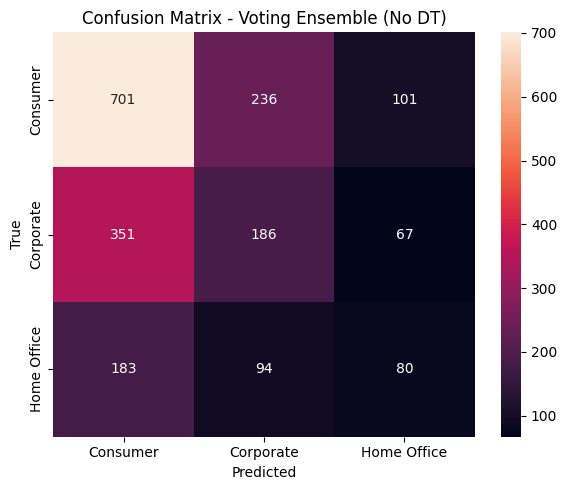

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=model.classes_,
    yticklabels=model.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Voting Ensemble (No DT)")
plt.tight_layout()
plt.show()


In [13]:
artifact = {
    "model": model,
    "drop_cols": drop_cols,
    "target_col": target_col
}

joblib.dump(artifact, "superstore_segment_voting.pkl")
print("Saved: superstore_segment_voting.pkl")


Saved: superstore_segment_voting.pkl
